In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    StandardScaler, OneHotEncoder, FunctionTransformer)
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import (
    train_test_split, KFold, GridSearchCV, ParameterGrid,)
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from datetime import datetime, timedelta
import keras
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#Reference https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
#Reference https://www.kaggle.com/code/nicholasjhana/univariate-time-series-forecasting-with-keras

## Data Preprocessing

In [2]:
#Read CSV
df = pd.read_csv("FinalData.csv", encoding = 'ISO-8859-1')

In [3]:
#Convert Date and Time of capture to datetime
df['Date and Time of capture'] = pd.to_datetime(df['Date and Time of capture'])

In [4]:
#Drop unwanted column
df = df.drop(["Unnamed: 0"], axis=1)

In [5]:
#Duplicate dataframe
df1 = df

In [6]:
#Set Date and Time of capture as index
df1 = df1.set_index(['Date and Time of capture'])

## Set up table with hour as column headings and date as row headings

In [7]:
def transform_to_hour_cols(series):
    df = pd.DataFrame()

    #go through full series
    start = series.index.min()
    end = series.index.max()
    
    #extracting date related variables from index
    df['year'] = series.index.year
    df['month'] = series.index.month
    df['day'] = series.index.day
    df['hour'] = series.index.hour
    df['minute'] = series.index.minute
    df['hour-minute'] = df['hour'] * 60 + df['minute']
    df['loads'] = series.values
    
    #drop unwanted variables
    df.drop(['hour', 'minute'], axis=1, inplace=True)
    
    #set up columns and rows
    df = df.set_index(['year', 'month', 'day', 'hour-minute'], append=True).unstack()
    df = df.groupby(['year', 'month', 'day']).sum()
    
    df.reset_index(inplace=True)
    #drop unwanted variables
    df.drop(['year', 'month', 'day'], axis=1, inplace=True)
    
    date_list = pd.date_range(start=start, end=end, freq='D').strftime('%Y-%m-%d')
    
    df.index = pd.DatetimeIndex(date_list, name='date')
    
    return df

daily_load = transform_to_hour_cols(df1['Total Parameter'])
daily_load.head()

C:\Users\nanan\AppData\Local\Temp\ipykernel_18744\1291980240.py:26: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df.drop(['year', 'month', 'day'], axis=1, inplace=True)


loads                                                        \
hour-minute     0        30       60       90       120      150      180    
date                                                                         
2011-09-01   707.889  705.840  724.357  713.332  706.644  710.311  711.336   
2011-09-02   691.673  695.691  698.831  708.976  707.940  683.686  700.220   
2011-09-03   728.551  682.485  654.568  651.858  644.285  626.736  617.168   
2011-09-04   748.005  696.291  708.840  693.670  690.724  679.839  666.842   
2011-09-05   676.084  677.687  663.785  662.166  673.934  678.492  673.581   

                                        ...                                \
hour-minute     210      240      270   ...      1140      1170      1200   
date                                    ...                                 
2011-09-01   716.035  715.766  720.075  ...  1077.252  1078.970  1079.152   
2011-09-02   699.530  694.731  711.379  ...  1050.299  1112.431  1089.049   
2011-09-03   620.842  622.490  639.985  ...  1022.888  1028.152  1045.211   
2011-09-04   676.442  667.542  684.814  ...   922.115   934.033   934.062   
2011-09-05   691.100  678.595  703.366  ...  1044.381  1056.574  1061.452   

                                                                             
hour-minute      1230     1260     1290     1320     1350     1380     1410  
date                                                                         
2011-09-01   1020.603  957.081  892.716  854.441  806.420  764.110  722.489  
2011-09-02   1029.917  984.426  920.075  884.210  832.468  799.815  773.998  
2011-09-03    984.575  956.347  930.292  873.857  843.000  821.408  799.978  
2011-09-04    907.511  875.347  830.107  822.417  764.089  718.736  687.009  
2011-09-05    987.199  931.263  856.800  828.086  791.051  751.524  710.288  

[5 rows x 48 columns]

## Normalize data

In [8]:
#Create function to normalize dataframes
def normalize_df(df):
    
    #normalize the dataset using MinMax scaler
    scaler = MinMaxScaler().fit(df.values)
    normalized_data = scaler.transform(df.values)
    
    #return as dataframe
    df = pd.DataFrame(normalized_data, index=df.index, columns=df.columns)
    
    return df, scaler

In [9]:
#normalize the energy dataframe
daily_load_normalized, scaler = normalize_df(daily_load)

## Data splitting 

In [10]:
#Reference https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
#Create function to split data
def data_splitting(data, steps, extra_lag=False, long_lag_step=7, maximum=30, idx=0, multivar=False):

    #if not adding extra lag 
    if not extra_lag:
        maximum = steps
        steps+=1
        
    
    X, y = list(), list()
    for i in range(len(data)):
        

        end = i + maximum
        
        #create a list with indexes
        slices = [x for x in range(end-1,end-steps, -1)] + [y for y in range(end-steps, i, -long_lag_step)]
        
        #reverse the slice indexes
        slices = list(reversed(slices))
        
        # if gone past last record
        if end > len(data)-1:
            break


        # assign input and output 
        seq_x = data[slices, :]
        seq_y = data[end, :]

        X.append(seq_x)
        y.append(seq_y)
        
    X = np.array(X)
    y = np.array(y)
    
    if multivar:
        y = y[:,idx]
    
    return X, y

In [11]:
#create the supervised learning problem
steps = 21

X, Y = data_splitting(daily_load_normalized.values, steps, extra_lag=True, long_lag_step=7, maximum=60, idx=0, multivar=False)

# LSTM Model

In [12]:
#Define LSTM model function
#Reference https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
#takes in parallel inputs and outputs an equal number of parallel outputs
def lstm_parallel_out(n_lags, n_hours, cells=50, learning_rate=5e-3):
    
    #define the model
    model = keras.models.Sequential()
    model.add(keras.layers.LSTM(cells, activation='relu', return_sequences=True, input_shape=(n_lags, n_hours)))
    model.add(keras.layers.LSTM(int(cells/2), activation='relu'))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(n_hours))
    
    #Optimizer used in model defined as Adam
    optimizer = keras.optimizers.Adam(lr=learning_rate)
    
    model.compile(optimizer=optimizer, loss='mae')
    
    return model

In [13]:
#Define cross validation test bench
#Reference https://www.kaggle.com/code/nicholasjhana/univariate-time-series-forecasting-with-keras
def crossval_testbench(X, y, n_crossvals, epochs=5, verbose=0):
    
    #Spliting and assigning columns shape
    n_hours = X.shape[-1]
    n_features = X.shape[1]
    
    timeseries = TimeSeriesSplit(n_splits=n_crossvals)

    #initalize lists to capture the output
    predictions = []
    actuals = []


    #run the LSTM model on each of the time series splits
    for train, test in timeseries.split(X, y):
        
        #initalize the lstm model with learning rate 0.005
        lstm_base = lstm_parallel_out(n_features, n_hours, learning_rate=5e-3)
        
        #fit model to X and y train
        lstm_base.fit(X[train], y[train], epochs=epochs, verbose=verbose, shuffle=False)
        
        #make predictions for X test
        predict = lstm_base.predict(X[test], verbose=verbose)

        #inverse transform the predictions and actual values
        prediction = scaler.inverse_transform(predict)
        actual = scaler.inverse_transform(y[test].copy())

        #save the results in a list
        predictions.append(prediction)
        actuals.append(actual)
        
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    
    return predictions, actuals

In [14]:
#Running cross validation for both predictions and actual values
preds, actuals = crossval_testbench(X, Y, 2, epochs=10, verbose=1)

Epoch 1/10
4/4 [==============================] - 4s 16ms/step - loss: 0.6080
Epoch 2/10
4/4 [==============================] - 0s 18ms/step - loss: 0.5470
Epoch 3/10
4/4 [==============================] - 0s 18ms/step - loss: 0.5101
Epoch 4/10
4/4 [==============================] - 0s 19ms/step - loss: 0.4796
Epoch 5/10
4/4 [==============================] - 0s 18ms/step - loss: 0.4543
Epoch 6/10
4/4 [==============================] - 0s 19ms/step - loss: 0.4448
Epoch 7/10
4/4 [==============================] - 0s 18ms/step - loss: 0.4099
Epoch 8/10
4/4 [==============================] - 0s 19ms/step - loss: 0.4143
Epoch 9/10
4/4 [==============================] - 0s 18ms/step - loss: 0.3943
Epoch 10/10
4/4 [==============================] - 0s 5ms/step


Epoch 1/10
7/7 [==============================] - 2s 11ms/step - loss: 0.5376
Epoch 2/10
7/7 [==============================] - 0s 12ms/step - loss: 0.4733
Epoch 3/10
7/7 [==============================] - 0s 13ms/step - loss: 0.4240
Epoch 4/10
7/7 [==============================] - 0s 14ms/step - loss: 0.3951
Epoch 5/10
7/7 [==============================] - 0s 14ms/step - loss: 0.3671
Epoch 6/10
7/7 [==============================] - 0s 13ms/step - loss: 0.3425
Epoch 7/10
7/7 [==============================] - 0s 14ms/step - loss: 0.3201
Epoch 8/10
7/7 [==============================] - 0s 14ms/step - loss: 0.3025
Epoch 9/10
7/7 [==============================] - 0s 14ms/step - loss: 0.2813
Epoch 10/10
4/4 [==============================] - 0s 11ms/step


### Calculating Model Error

In [15]:
#MAPE function
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [16]:
#MAPE for a specific hour
error = mean_absolute_percentage_error(actuals[0,:5,0], preds[0, :5,0])
print(f'MAPE: {round(error, 2)}')

MAPE: 7.16


In [17]:
#Reference https://www.kaggle.com/code/nicholasjhana/univariate-time-series-forecasting-with-keras
crossvals = actuals.shape[0]
hours = actuals.shape[2]
errors_crossvals = list()
#Calculating MAPE for crossvalited values 
for crossval in range(crossvals):
    errors_hourly = [mean_absolute_percentage_error(actuals[crossval, :, hour], preds[crossval, :, hour]) for hour in range(hours)]
    errors_crossvals.append(errors_hourly)
#Attributing error values to dataframe
errors = pd.DataFrame(errors_crossvals)
errors['mean'] = errors.mean(axis=1)
errors.index.name='crossval set'
errors.columns.name='hours'

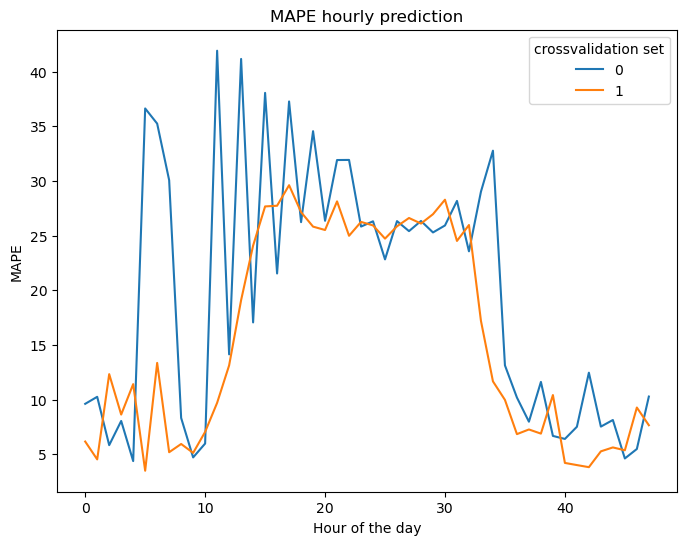

In [18]:
#Plot MAPE for hourly prediction
plt.figure(figsize=(8,6))
plt.plot(errors.drop(columns='mean').T)
plt.title('MAPE hourly prediction')
plt.legend(errors.index, title='crossvalidation set')
plt.xlabel('Hour of the day')
plt.ylabel('MAPE')
plt.savefig('LSTM_MAPE.png')
plt.show()

In [19]:
#Reference https://www.kaggle.com/code/nicholasjhana/univariate-time-series-forecasting-with-keras
#Creating function to split the dataframes into train and test
def train_test_split(df, split_date):
    
    
    train_date = pd.Timestamp(split_date).strftime('%Y-%m-%d')
    test_date = (pd.Timestamp(split_date) + timedelta(1)).strftime('%Y-%m-%d')
    
    df_train = df[:train_date]
    df_test = df[test_date:]
    
    return df_train, df_test

#Leave last 2 months of data for testing
train, test = train_test_split(daily_load, '2012-06-30')

In [20]:
#Creating validation dataset from last day data
valid = test.iloc[[-1]]
test = test[:-1]

In [21]:
#Normalise both train and test datasets
train_normalized, scalar = normalize_df(train)
test_normalized = scalar.transform(test)

#create the supervised learning problem
n_steps = 21

#Split data
X_train, Y_train = data_splitting(train_normalized.values, steps, extra_lag=True, long_lag_step=7, maximum=60, idx=0, multivar=False)


In [22]:
test_set = np.vstack([train_normalized.values[-60:], test_normalized])
X_test, Y_test = data_splitting(test_set, steps, extra_lag=True, long_lag_step=7, maximum=60, idx=0, multivar=False)

In [23]:
#Reference https://www.kaggle.com/code/nicholasjhana/univariate-time-series-forecasting-with-keras
n_features=X_train.shape[1]
n_hours=X_train.shape[2]
#initalize the lstm model
lstm_model_evaluation = lstm_parallel_out(n_features, n_hours, learning_rate=5e-3)
        
#fit the model
lstm_model_evaluation.fit(X_train, Y_train, epochs=350, verbose=1, shuffle=False)
        
#check predictions on the train set
train_predictions = lstm_model_evaluation.predict(X_train, verbose=1)

#run predictions on test data
test_predictions = lstm_model_evaluation.predict(X_test, verbose=1)

Epoch 1/350
8/8 [==============================] - 2s 12ms/step - loss: 0.5043
Epoch 2/350
8/8 [==============================] - 0s 12ms/step - loss: 0.4331
Epoch 3/350
8/8 [==============================] - 0s 13ms/step - loss: 0.4039
Epoch 4/350
8/8 [==============================] - 0s 14ms/step - loss: 0.3817
Epoch 5/350
8/8 [==============================] - 0s 14ms/step - loss: 0.3622
Epoch 6/350
8/8 [==============================] - 0s 14ms/step - loss: 0.3271
Epoch 7/350
8/8 [==============================] - 0s 15ms/step - loss: 0.3022
Epoch 8/350
8/8 [==============================] - 0s 14ms/step - loss: 0.2833
Epoch 9/350
8/8 [==============================] - 0s 14ms/step - loss: 0.2750
Epoch 10/350
8/8 [==============================] - 0s 14ms/step - loss: 0.2543
Epoch 11/350
8/8 [==============================] - 0s 15ms/step - loss: 0.2508
Epoch 12/350
8/8 [==============================] - 0s 15ms/step - loss: 0.2390
Epoch 13/350
8/8 [==============================]

8/8 [==============================] - 0s 20ms/step - loss: 0.1067
Epoch 104/350
8/8 [==============================] - 0s 20ms/step - loss: 0.1027
Epoch 105/350
8/8 [==============================] - 0s 20ms/step - loss: 0.0975
Epoch 106/350
8/8 [==============================] - 0s 21ms/step - loss: 0.1005
Epoch 107/350
8/8 [==============================] - 0s 20ms/step - loss: 0.0992
Epoch 108/350
8/8 [==============================] - 0s 20ms/step - loss: 0.1004
Epoch 109/350
8/8 [==============================] - 0s 20ms/step - loss: 0.0925
Epoch 110/350
8/8 [==============================] - 0s 20ms/step - loss: 0.0996
Epoch 111/350
8/8 [==============================] - 0s 20ms/step - loss: 0.0972
Epoch 112/350
8/8 [==============================] - 0s 20ms/step - loss: 0.0953
Epoch 113/350
8/8 [==============================] - 0s 20ms/step - loss: 0.1016
Epoch 114/350
8/8 [==============================] - 0s 20ms/step - loss: 0.0984
Epoch 115/350
8/8 [=======================

8/8 [==============================] - 0s 20ms/step - loss: 0.0847
Epoch 205/350
8/8 [==============================] - 0s 20ms/step - loss: 0.0827
Epoch 206/350
8/8 [==============================] - 0s 20ms/step - loss: 0.0852
Epoch 207/350
8/8 [==============================] - 0s 20ms/step - loss: 0.0839
Epoch 208/350
8/8 [==============================] - 0s 20ms/step - loss: 0.0867
Epoch 209/350
8/8 [==============================] - 0s 21ms/step - loss: 0.0883
Epoch 210/350
8/8 [==============================] - 0s 20ms/step - loss: 0.0818
Epoch 211/350
8/8 [==============================] - 0s 20ms/step - loss: 0.0835
Epoch 212/350
8/8 [==============================] - 0s 21ms/step - loss: 0.0798
Epoch 213/350
8/8 [==============================] - 0s 21ms/step - loss: 0.0809
Epoch 214/350
8/8 [==============================] - 0s 20ms/step - loss: 0.0866
Epoch 215/350
8/8 [==============================] - 0s 20ms/step - loss: 0.0890
Epoch 216/350
8/8 [=======================

8/8 [==============================] - 0s 20ms/step - loss: 0.0782
Epoch 306/350
8/8 [==============================] - 0s 20ms/step - loss: 0.0818
Epoch 307/350
8/8 [==============================] - 0s 20ms/step - loss: 0.0846
Epoch 308/350
8/8 [==============================] - 0s 20ms/step - loss: 0.0809
Epoch 309/350
8/8 [==============================] - 0s 20ms/step - loss: 0.0743
Epoch 310/350
8/8 [==============================] - 0s 20ms/step - loss: 0.0806
Epoch 311/350
8/8 [==============================] - 0s 20ms/step - loss: 0.0826
Epoch 312/350
8/8 [==============================] - 0s 21ms/step - loss: 0.0776
Epoch 313/350
8/8 [==============================] - 0s 20ms/step - loss: 0.0767
Epoch 314/350
8/8 [==============================] - 0s 20ms/step - loss: 0.0788
Epoch 315/350
8/8 [==============================] - 0s 19ms/step - loss: 0.0781
Epoch 316/350
8/8 [==============================] - 0s 20ms/step - loss: 0.0766
Epoch 317/350
8/8 [=======================

In [24]:
#Scaling and transforming the values back to original scale
train_preds = scalar.inverse_transform(train_predictions)
test_preds = scalar.inverse_transform(test_predictions)
Y_train = scalar.inverse_transform(Y_train)
Y_test = scalar.inverse_transform(Y_test)

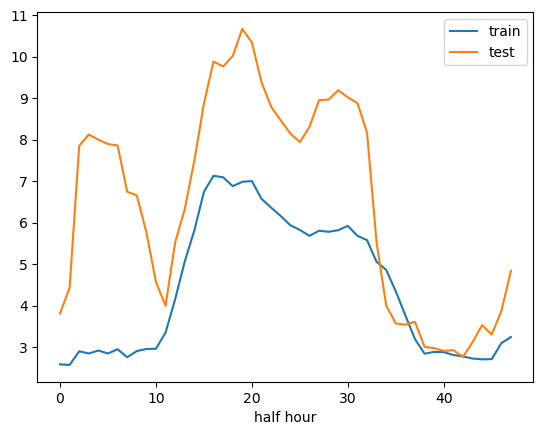

In [25]:
#Calculating and plotting model erros when predicting for half hour
train_error = pd.DataFrame([mean_absolute_percentage_error(Y_train[:, hour], train_preds[:, hour]) for hour in range(hours)], columns=['train'])
test_error = pd.DataFrame([mean_absolute_percentage_error(Y_test[:, hour], test_preds[:, hour]) for hour in range(hours)], columns=['test'])

errors = pd.concat([train_error, test_error], axis=1)
errors.index.name = 'half hour'
errors.plot()
plt.savefig('LSTM_HALFHOUR.png')

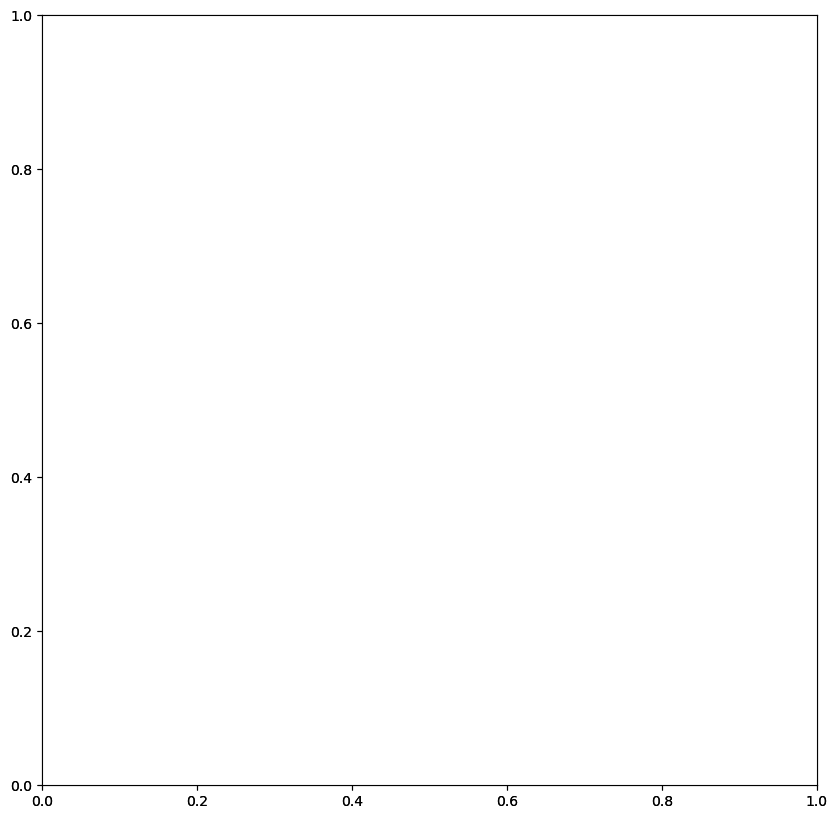

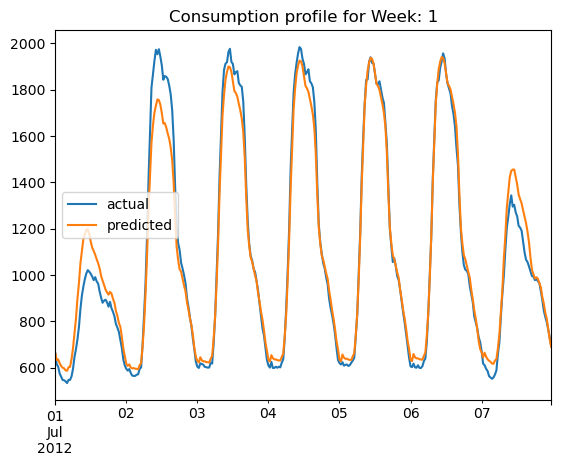

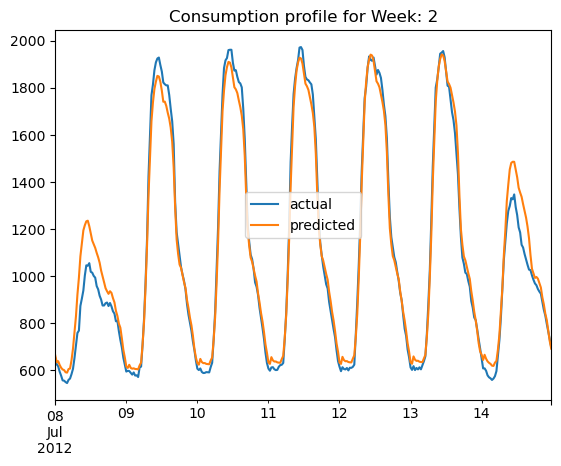

In [26]:
#Reference https://www.kaggle.com/code/nicholasjhana/univariate-time-series-forecasting-with-keras
#Assigning prediction values and actual values to variables
test_df = pd.DataFrame(test_preds).stack()
Y_test_df = pd.DataFrame(Y_test).stack()

#Merging both dataframes into one
preds_df = pd.concat([Y_test_df, test_df], axis=1)
preds_df.columns = ['actual', 'predicted']

#Selecting the prediction period with a frequency of half an hour
preds_df.index = pd.DatetimeIndex(pd.date_range(start='2012-07-01T0000', end='2012-08-29T2330', freq='30min'))

#Ploting actual values against predicted values on a weekly basis
fig = plt.figure(figsize=(10,10))
for week in range(2):

    fig.add_subplot()
    preds_df.iloc[week*7*48:(week+1)*7* 48].plot()
    plt.title(f'Consumption profile for Week: {week+1}')
plt.savefig('LSTMWEEK.png')

In [27]:
#Calculate MAPE 
error = mean_absolute_percentage_error(preds_df['actual'], preds_df['predicted'])
print(f'LSTM MAPE: {error:.2f} %')

LSTM MAPE: 6.51 %


## Day Ahead Prediction

In [28]:
#Scaling/Normalizing validation dataset 
valid_normalized = scalar.transform(valid)

#Dataset with normalized values
valid_dataset = np.vstack([train_normalized.values[-60:], valid_normalized])

#Split data into X and Y 
X_valid, Y_valid = data_splitting(valid_dataset, steps, extra_lag=True, long_lag_step=7, maximum=60, idx=0, multivar=False)

#Run prediction for last day
valid_predictions = lstm_model_evaluation.predict(X_valid, verbose=1)

1/1 [==============================] - 0s 31ms/step


In [29]:
#Scaling and transforming the values back to original scale
valid_preds = scalar.inverse_transform(valid_predictions)
Y_valid = scalar.inverse_transform(Y_valid)

<Figure size 1000x1000 with 0 Axes>

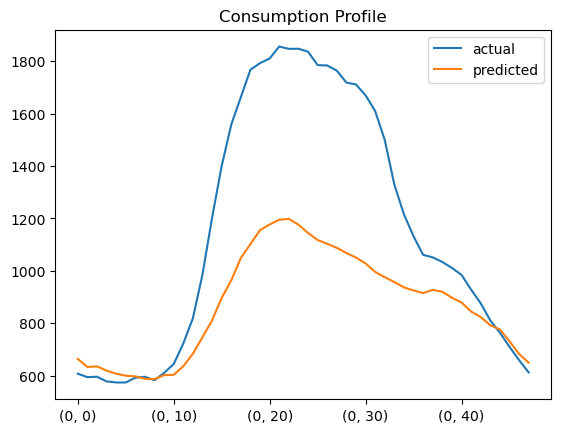

In [30]:
#Plotting actual and predicted values from day ahead prediction
valid_df = pd.DataFrame(valid_preds).stack()
Y_valid_df = pd.DataFrame(Y_valid).stack()

preds_df = pd.concat([Y_valid_df, valid_df], axis=1)
preds_df.columns = ['actual', 'predicted']

fig = plt.figure(figsize=(10,10))
preds_df.plot()
plt.title(f'Consumption Profile')
plt.savefig('LSTMVALUES.png')